# Capability Correlations

Let's start by importing all of the necessary libraries to conduct the analysis. 

In [95]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats
from sklearn.cluster.bicluster import SpectralBiclustering


# please add your plotly api credentials to plotly_config in your own machine. Visit https://plot.ly/python/getting-started/
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

### Table of Contents:
- [1. Database Matrix of Occurences](#one)
  - [1.1. Getting the data from Neo4j](#one-one)
  - [1.2. Designing the queries](#one-two)    
  - [1.3. The first part of the matrix: No intersections.](#one-three)
  - [1.4. The second part of the matrix: Intersections.](#one-four)
  - [1.5. Testing the co-occurence matrix](#one-five)
  - [1.6. Printing the matrix](#one-six)
- [2. Co-occurence by country](#two)
  - [2.1. Co-ocurence matrixes for countries](#two-one)
  - [2.2. Transforming the co-occurence matrix into a list](#two-two)
  - [2.3. Visualizing correlations](#two-three)
  - [2.4. Creating a correlation matrix](#two-four)
    - [2.4.1. Regular Matrix](#two-four-one)
    - [2.4.2. Reordered Matrix: Biclustering](#two-four-two)
    - [2.4.3. Reordered Matrix: Clustermap](#two-four-three)
  - [2.5. Country profiles](#two-five)
- [3. Contextual Relations](#three)
  - [3.1. GDP](#three-one)

## 1. Database Matrix of Occurences <a class="anchor" id="one"></a>

In order to establish a base for understading the basis of the work, we wish to understand the occurence of severall feedstocks, processing technologies and outputs in our database. 

For example, how many assets (patents, papers, etc) contain the mix of processing technology X for output Y? 

To understand this in a more general way, the [AMICA](https://amica-pathfinder.net/) database will be transformed in an [co-occurence matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix). This means, in the above described example that the number of assets that contain that mix will be an entry in a matrix, whyle the corresponfing technology and output will be columns/lines of the matrix. 

### 1.1. Getting the data from Neo4j <a class="anchor" id="one-one"></a>

The first step in the analysis is to get the data from the [AMICA](https://amica-pathfinder.net/) database. This data is stored in a graph database of the type [Neo4j](https://neo4j.com/). 

We use [py2neo](http://py2neo.org/v3/) to establish a connection to the neo4j database. 

In [96]:
local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

### 1.2. Designing the queries <a class="anchor" id="one-two"></a>

Two queries to the database were designed, the first, only related to non intersecting data, this means, looking for co-occurences of:
- outputs and technologies that appear together in an asset. 
- technologies and feedstocks that appear together in an asset.   
- feedstocks and outputs that appear together in an asset. 

In [97]:
query_no_interestions = """     MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                RETURN fs.term, pt.term, out.term, count(a)
                        """

The second query is designed to also fetch the intersections between different outputs, different processing technologies and different feedstocks. This relates to: 
- outputs that appear together in the same asset. 
- technologies that appear together in the same asset.
- outputs that appear together in the same asset. 

In [98]:
# issue: this query needs to be divided by two when building the matrix -> NON OPTIMIZED
process_variables = ['Feedstock', 'Output', 'ProcessingTech']
query_intersections = """       MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                WHERE fs<>t
                                RETURN fs.term, t.term, count(a)
                      """

### 1.3. The first part of the matrix: No intersections. <a class="anchor" id="one-three"></a>

In order to get the axis of our co-occurence matrix we make all the necessary queries and gather all the names that appear in a `matrix_axis_names` list.

In [99]:
# Return query as pandas dataframe 
data_no_intersections = DataFrame(connection_to_graph.data(query_no_interestions)).as_matrix()

# Get axis names from columns and append to list
feedstock_names = set(list(data_no_intersections[:, 1]))
processing_technology_names = set(list(data_no_intersections[:, 2]))
output_names = set(list(data_no_intersections[:, 3]))
matrix_axis_names = list(feedstock_names) + list(processing_technology_names) + list(output_names)

# Extra labels that only appear in non-intersection queries
for category in process_variables:
    data_no_intersections = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    for column_number in range(1,3):
        column = data_no_intersections[:, column_number]
        for name in column:
            if name not in matrix_axis_names:
                matrix_axis_names.append(name)

The co-occurence matrix will be called `matrix`. In order to get things started we need two things: 

- An empty matrix with the shape of the previously built axis:

In [100]:
matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])

- A function that given a certain name, returns the position of that name in a list:

In [101]:
def find_index(something, in_list):
    return in_list.index(something)

Finally, we can start building the first part of the matrix. To do so, we iterated over all of the rows of the data retreived in the `data_no_intersections` table. 

In [102]:
# for every row in original response
for row in data_no_intersections:
    # the last column is the frequency 
    frequency = row[0]
    indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
    # add frequency value to matrix position
    for pair in itertools.combinations(indexes, 2):
        matrix[pair[0], pair[1]] += frequency
        matrix[pair[1], pair[0]] += frequency

### 1.4. The second part of the matrix: Intersections. <a class="anchor" id="one-four"></a>

The second part of the matrix that should be built related to the second query. Intersecting categories. 

In [103]:
# for every type of asset
for category in process_variables:
    print 'Processing ', category
    # execute the query 
    process_data = DataFrame(connection_to_graph.data(query_intersections.format(category, category))).as_matrix()
    # fill the matrix
    for row in process_data:
        frequency = row[0]
        indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
        #     add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
            matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized

Processing  Feedstock
Processing  Output
Processing  ProcessingTech


### 1.5. Testing the co-occurence matrix <a class="anchor" id="one-five"></a>

Some basic statistics about the co-occurence matrix. 

In [104]:
print 'Rows:', matrix.shape[0]
print 'Columns:', matrix.shape[1]
print 'Mean: ', np.mean(matrix)
print 'Standart Deviation', np.std(matrix)
print 'Max: ', np.amax(matrix)
print 'Min: ', np.amin(matrix)

Rows: 342
Columns: 342
Mean:  1.3187989466844499
Standart Deviation 15.649910770705663
Max:  1626.0
Min:  0.0


After testing, we normalize the matrix.

In [105]:
normalized_matrix = (matrix - np.mean(matrix)) / np.std(matrix)

Symmetricality verification of normalized and non-normlized co-occurence matrixes. 

In [106]:
def check_symmetric(a, tol):
    return np.allclose(a, a.T, atol=tol)

print 'The non normalized matrix is symmetrical: {}'.format(check_symmetric(matrix, 1e-8))
print 'The normalized matrix is symmetrical: {}'.format(check_symmetric(normalized_matrix, 1e-8))

The non normalized matrix is symmetrical: True
The normalized matrix is symmetrical: True


The following cell will verify if there is a non-zero element in the diagonal of the matrix. 

In [107]:
for column_number in range(matrix.shape[0]):
    if matrix[column_number, column_number] != 0:
        print 'Non-zero entry found in entry {}'.format(column_number)

### 1.6. Printing the matrix <a class="anchor" id="one-six"></a>

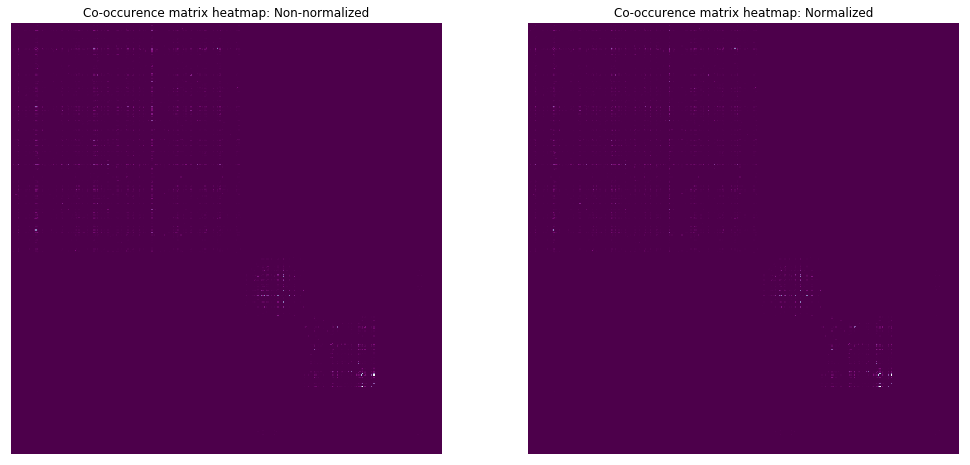

In [108]:
# create subplots
plt.subplots(2,1,figsize=(17,17))

plt.subplot(121)
sns.heatmap(matrix, cmap='BuPu_r',  cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Co-occurence matrix heatmap: Non-normalized')

plt.subplot(122)
sns.heatmap(normalized_matrix, cmap='BuPu_r', cbar=None, square=True, xticklabels=False, yticklabels=False)
plt.title('Co-occurence matrix heatmap: Normalized')
plt.show()

## 2. Co-occurences and countries <a class="anchor" id="two"></a>

In this part of the analysis, severall co-occurence matrixes will be produced. Ideally, one for every country in the database. 

### 2.1. Co-ocurence matrixes for countries <a class="anchor" id="two-one"></a>

We start by getting a list of all of the countries in the neo4j database. 

In [109]:
country_query = """ MATCH (n:Country) 
                    WITH n.name AS Country 
                    RETURN Country;
                    """

country_names = list(set(DataFrame(connection_to_graph.data(country_query)).as_matrix()[:, 0]))
country_names.sort()

print 'The country list has {} countries.'.format(len(country_names))

The country list has 145 countries.


After doing this, we prepare a function that given a certain country, will retrieve the co-occurence matrix. This process is similar to the process in "[1.3. The first part of the matrix: No intersections](#one-three)" but applied to a particular country. By aggregating the process done before in a single function. 

In [110]:
def get_country_matrix(country, normalization=True):
    
    # define queries
    country_no_interestions = """   MATCH (a:Asset)-[:CONTAINS]->(fs:Feedstock)
                                    MATCH (a:Asset)-[:CONTAINS]->(out:Output)
                                    MATCH (a:Asset)-[:CONTAINS]->(pt:ProcessingTech)
                                    WHERE a.country = "{}"
                                    RETURN fs.term, pt.term, out.term, count(a)
                                    """.format(country)
    
    process_variables = ['Feedstock', 'Output', 'ProcessingTech']
    
    country_intersections = """     MATCH (a:Asset)-[:CONTAINS]->(fs:{})
                                    MATCH (a:Asset)-[:CONTAINS]->(t:{})
                                    WHERE fs<>t AND a.country = "{}"
                                    RETURN fs.term, t.term, count(a)
                                    """
    # get data
    data_no_intersections = DataFrame(connection_to_graph.data(country_no_interestions)).as_matrix()
    
    # create matrix
    country_matrix = np.zeros([len(matrix_axis_names), len(matrix_axis_names)])
    
    # for no intersections data
    for row in data_no_intersections:
        # the last column is the frequency (count)
        frequency = row[0]
        indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
        # add frequency value to matrix position
        for pair in itertools.combinations(indexes, 2):
            country_matrix[pair[0], pair[1]] += frequency
            country_matrix[pair[1], pair[0]] += frequency
    
    # for intersecting data
    for category in process_variables:
        process_data = DataFrame(connection_to_graph.data(country_intersections.format(category, category, country))).as_matrix()
        for row in process_data:
            frequency = row[0]
            indexes = [find_index(element, matrix_axis_names) for element in row[1::]]
            # add frequency value to matrix position
            for pair in itertools.combinations(indexes, 2):
                country_matrix[pair[0], pair[1]] += frequency / 2 # Divided by two because query not optimized
                country_matrix[pair[1], pair[0]] += frequency / 2 # Divided by two because query not optimized
    
    # normalize
    normalized_country_matrix = (country_matrix - np.mean(country_matrix)) / np.std(country_matrix)
    
    # dynamic return 
    if normalization == True:
        return normalized_country_matrix
    else: 
        return country_matrix

Let's create a function that returns basic stats given a matrix. With this function, we can gain insight into the previous function. 

In [111]:
def basic_stats(a_matrix):
    print 'Rows:', a_matrix.shape[0]
    print 'Columns:', a_matrix.shape[1]
    print 'Mean: ', np.mean(a_matrix)
    print 'Standart Deviation', np.std(a_matrix)
    print 'Max: ', np.amax(a_matrix)
    print 'Min: ', np.amin(a_matrix)
    print 'Symmetry: ', check_symmetric(matrix, 1e-8)
    print ''

Let's test a couple of countries. By getting their co-occurence matrix and printing its properties. 

In [112]:
print 'Denmark co-occurence matrix stats:'
basic_stats(get_country_matrix('Denmark', normalization=True))
print 'Sweden co-occurence matrix stats:'
basic_stats(get_country_matrix('Sweden', normalization=True))

Denmark co-occurence matrix stats:
Rows: 342
Columns: 342
Mean:  2.2477070913378225e-17
Standart Deviation 1.0
Max:  98.71619845088439
Min:  -0.043307401534452276
Symmetry:  True

Sweden co-occurence matrix stats:
Rows: 342
Columns: 342
Mean:  7.046865475545606e-18
Standart Deviation 1.0
Max:  111.13602822340711
Min:  -0.06205868957115324
Symmetry:  True



### 2.2. Transforming the co-occurence matrix into a list <a class="anchor" id="two-two"></a>

One of the goals of the analysis is to understand how each country relates to another. To do this, we will need to transform the matrix of a given country into an array. 

After doing this we will be able to compare the array of each one of the countries, by computing their difference or correlation for example. 

Let's start by creating a function that given a symetric matrix, as the ones shown above, returns a list. This list will have an entry by position in the matrix. But since the matrixes are symmetrical, the list will only receive half of the matrix. 

This means that for a matrix of dimensions 342x342 the list will have a total of 58 482 entries. 

In [113]:
def get_list_from(matrix):
    only_valuable = []
    extension = 1
    for row_number in range(matrix.shape[0]):
        only_valuable.append(matrix[row_number, extension:matrix.shape[0]].tolist()) # numpy functions keep 0s so I hard coded it. 
        extension += 1 
    return [element for column in only_valuable for element in column ]

### 2.3. Visualizing correlations <a class="anchor" id="two-three"></a>

Let's visualize the lists produced by this workflow for two different countries. 

We first select two countries.

In [114]:
spectrum_countries = ['''People's Republic of China''', 'United States of America']

We then create a matrix where each row is the vector that describes the country's capabilities.

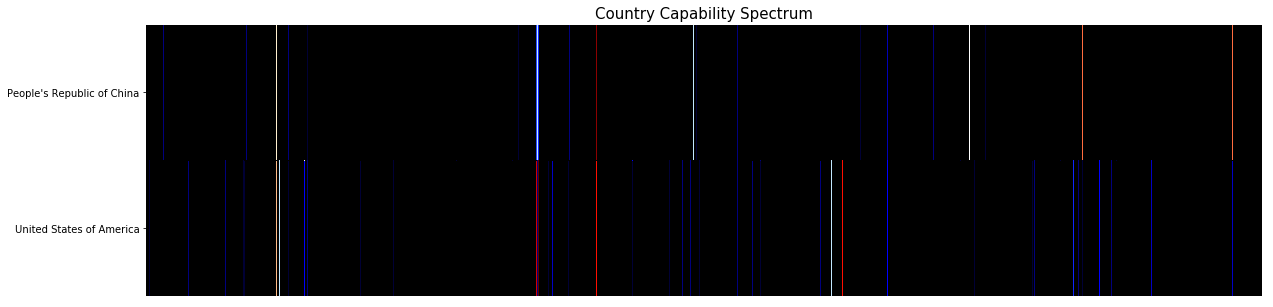

In [115]:
# apply functions to both countries
country_1_list = get_list_from(get_country_matrix(spectrum_countries[0], normalization=True))
country_2_list = get_list_from(get_country_matrix(spectrum_countries[1], normalization=True))

# create a matrix where each row is a list of a country
corelation = np.vstack((country_1_list, country_2_list))

# plot the matrix 
plt.subplots(1,1,figsize=(20, 5))
plt.subplot(111)
sns.heatmap(corelation, cmap='flag_r', cbar=None, square=False, yticklabels=[spectrum_countries[0], spectrum_countries[1]], xticklabels=False)
plt.yticks(rotation=0)
plt.title('Country Capability Spectrum', size=15)
plt.show()

We can see that the spectrum differs significantly in some areas. Please note that all of the measure were normalized prior to the plotting.

### 2.4. Creating a correlation matrix <a class="anchor" id="two-four"></a>

#### 2.4.1. Regular Matrix <a class="anchor" id="two-four-one"></a>

In this part of the analysis we will start correlating countries in relation to their capabilities. 

The correlation matrix follows the following principle: 
- Entry (i, j) is the correlation index between country i and country j
- The correlation index between country i and j is the absolute average difference between the capability list of country i and j.

Now, taking the list of countries previously established, we can iterate through it and fill the matrix. 

To improve eficiency, we first create a dictionnary where each key is a country, and each value, the capability list.

In the case that the databse contains no assets about a certain country, that country will be discarted. 

In [116]:
# create dictionnary
country_capability_dict = {}
counter = 0

# iterate through countries
for country in country_names:
    counter += 1
    country_matrix = get_country_matrix(country, normalization=True)
    
    # discart if no information
    if np.all(np.isnan(country_matrix)):
        continue
    else: 
        country_capability_dict[country] = get_list_from(country_matrix)

np.save('Data/country_capability_dict.npy', country_capability_dict) 

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning:

invalid value encountered in divide



Let's create a function that given two countries and a method, returns a suitable correlation coeficient. 

Here, the code will give three possible outputs: 
- `abs_avg_dif`: the absolute average difference between two vectors.
- `Pearson`: The [pearson](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html) correlation coeficient between two vectors. 
- `P-value`: The p-value according to [scipy](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html).

In [117]:
def calculate_country_correlation(country1_list, country2_list, stat):
    avg_dif = np.mean(country1_list - country2_list)
    abs_avg_dif = abs(avg_dif)
    
    if stat.lower() == 'absolute average difference': # return absolute average difference
        return abs_avg_dif
    if stat == 'Pearson':                             # return Pearson coef
        return stats.pearsonr(country1_list, country2_list)[0]
    if stat == 'P-value':                             # return P-value
        return stats.pearsonr(country1_list, country2_list)[1]

The matrix is built, with the following steps: 
1. For each country, get its asset co-occurence matrix.
2. Normalize the matrix by subtracting the mean and dividing by the standard deviation. 
3. Transform the matrix into a list by taking its upper triangle. 
4. For each entry (i,j) of the matrix, calculate the correlation of the list of country i and the list of country j. 

In [118]:
country_names = country_capability_dict.keys()
country_names.sort()
number_of_countries = len(country_names)
country_correlation = np.zeros([number_of_countries, number_of_countries])

for row in range(number_of_countries):
    print 'Processing country {} / {} \r'.format(row + 1, number_of_countries),
    country_1 = country_names[row]
    country_1_list = np.asarray(country_capability_dict[country_1])
    for column in range(number_of_countries):
        country_2 = country_names[column]
        country_2_list = np.asarray(country_capability_dict[country_2])

        country_correlation[row, column] = calculate_country_correlation(country_1_list, country_2_list, 'Pearson')

np.save('Data/country_correlation.npy', country_correlation)
np.save('Data/country_names.npy', country_names)

After building the matrix, we create the first heatmap of that matrix using the `sns.heatmap` function. 

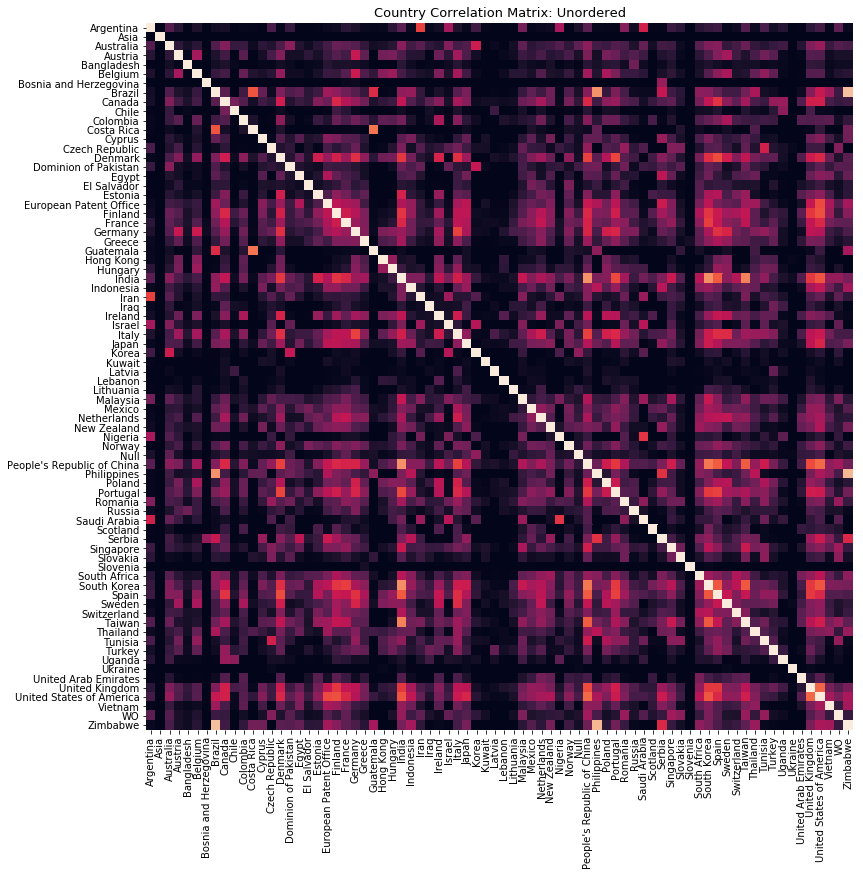

In [119]:
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(country_correlation, cbar=None, square=True, yticklabels=country_names, xticklabels=country_names)
plt.title('Country Correlation Matrix: Unordered', size=13)
plt.show()

A couple of things worth noting in the first visualization: 
- All of the values of the heatmap are between 0 and 1. 
- A value of 1 indicates the highest level of correlation. For this reason, the diagonal has values equal to 1.(This because it corresponds to the correaltion of a country to itself.) 
- The lighter the color of the correlation, the higher the level of correlation. 
- If a cell in the heatmap is totally dark, this indicates no correlation at all. 

**Light Cell - High Correlation:** This indicates that the capability profile of the two countries concerned is similar. Which can be interpreted as the countries having "similar" research profiles. 

**Dark Cell - Low Correlation:** This indicates that the capability profile of the two countries concerned is different. Which can be interpreted as the countries having divergent research profiles. 

[INTERACTIVE PLOTLY VERSION.](https://plot.ly/~duarteocarmo/22)

#### 2.4.2. Reordered Matrix: Biclustering <a class="anchor" id="two-four-two"></a>

Let's try to cluster the matrix above in order to provide a more meaningful visualization. 

To do this, we use a biclustering algorithm found in [SciKit](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.bicluster.SpectralBiclustering.html#sklearn.cluster.bicluster.SpectralBiclustering.fit)

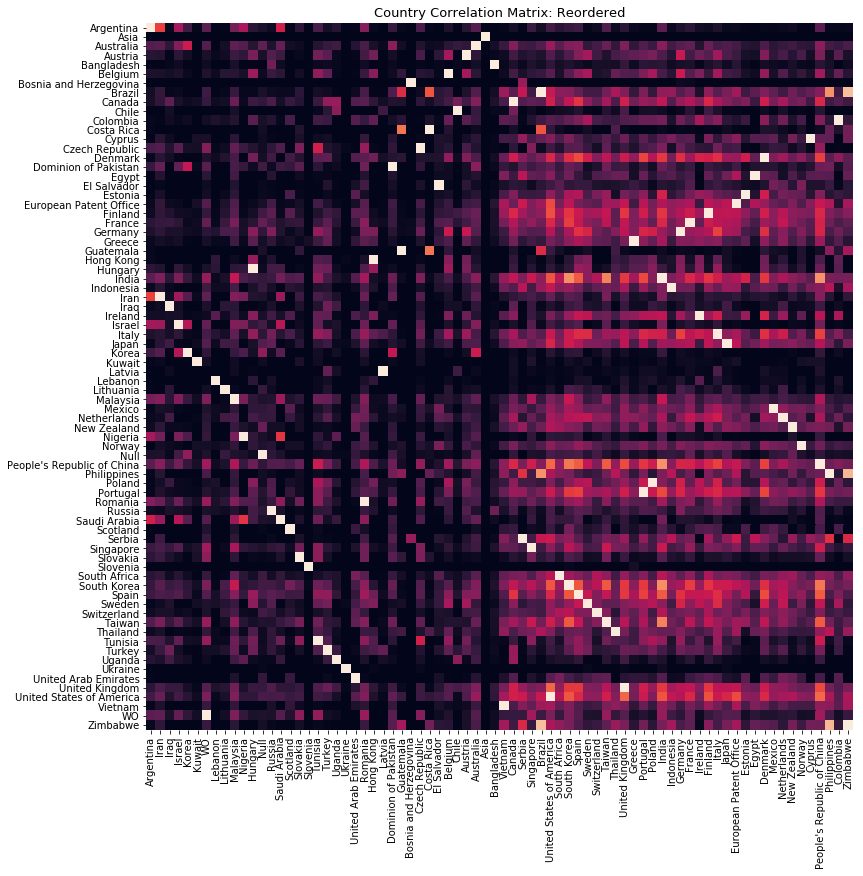

In [120]:
# define number of clusters and method. 
n_clusters = (2, 2)
chosen_method = 'log'
# ‘scale’, ‘bistochastic’, or ‘log’, recommended is log but default is bistochastic

# fit model
model = SpectralBiclustering(n_clusters=n_clusters, method=chosen_method, random_state=0)
model.fit(country_correlation)

# create new matrix
fit_data = country_correlation[np.argsort(model.row_labels_)]
fit_data = country_correlation[:, np.argsort(model.column_labels_)]

# rearrange labels
idx = np.argsort(model.row_labels_)
names = np.asarray(country_names)

# plot
plt.subplots(1,1,figsize=(13, 13))
plt.subplot(111)
sns.heatmap(fit_data,  cbar=None, square=True, yticklabels=country_names, xticklabels=names[idx])
plt.title('Country Correlation Matrix: Reordered', size=13)
plt.show()

This first attempt at reordering does not produce significant results. 

#### 2.4.3. Reordered Matrix: Clustermap <a class="anchor" id="two-four-three"></a>

In this part, we will create a clustermap of the heatmap produced in the previous sections. 

To do this, we use the `sns.clustermap` function (see documentation [here](http://seaborn.pydata.org/generated/seaborn.clustermap.html)) that produces two things: 
- A reordered heatmap according to 'similarity'. This method reorders the matrix using Hierarchical agglomerative clustering with single linkage (minimum distance). See more info about this algorithm [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). 
- This clustermap also creates a [dendogram](https://en.wikipedia.org/wiki/Dendrogram) of the linkages that the algorithm produces.


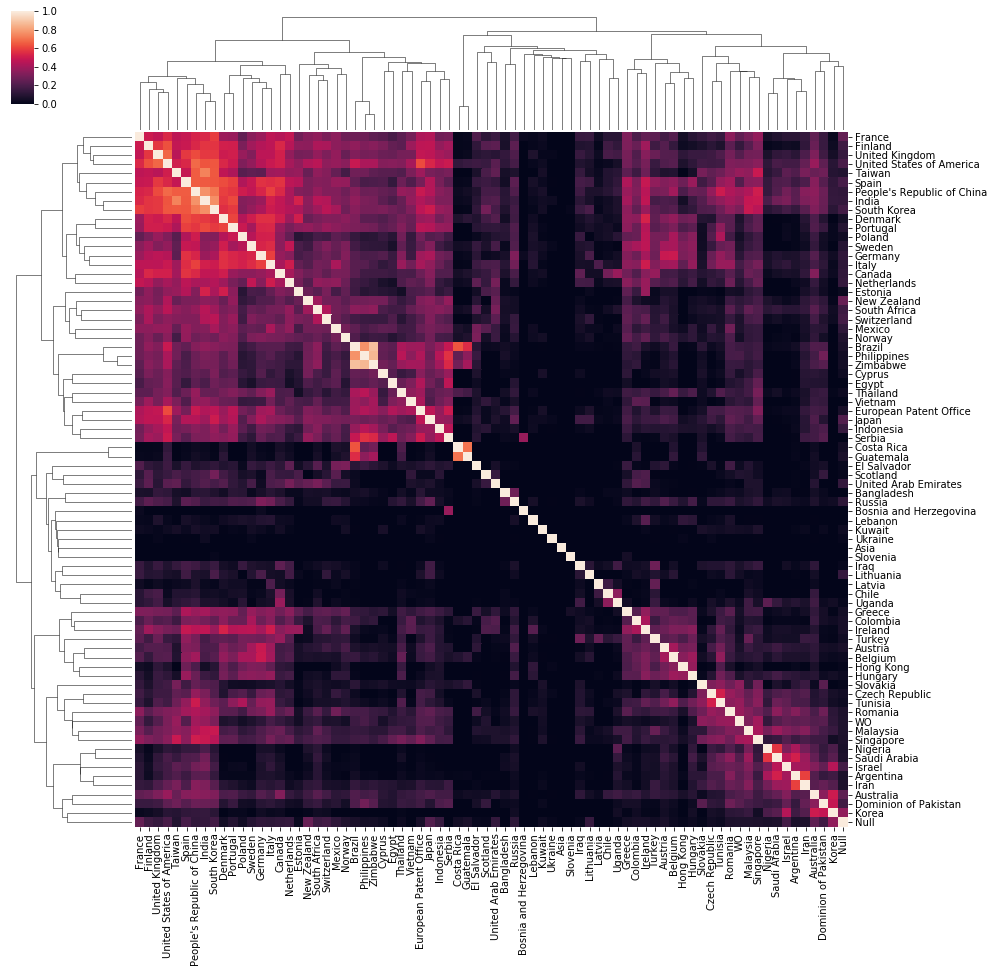

In [121]:
# plot the clustermap
a = sns.clustermap(country_correlation,  figsize=(15, 15), xticklabels = country_names, yticklabels=country_names)
plt.show()

# verification that labels are correctly put. 
#label_verif = []
#for number in a.dendrogram_col.reordered_ind:
#    label_verif.append((number, country_names[number]))
#    
#print label_verif

Some interesting observations and hypothesis: 
- **History and Culture matter:** UK and USA, for example, are highly correlated. (68% correlation)
- **Distance Matters: ** Costa-Rica and Guatemala have a correlation of 71%.
- **Other Factors might matter: **: Portugal and Denmark for example, have a correlation of 61%. 


*PS: the percentage of correlation is achieved by multiplying the Pearson correlation index by 100.* 

### 2.5. Country profiles <a class="anchor" id="two-five"></a>

Another interesting analysis is understanding how one country relates to other countries itself. This is done by *slicing* the heatmap produced in the previous section. 

By producing a bar plot for every country we can see how it relates to others and possibly find meaningful patterns. 

Let's start by selecting a couple of countries:

In [122]:
countries = ['United Kingdom', 'Denmark']

After selecting countries, we can now plot two different profiles. 

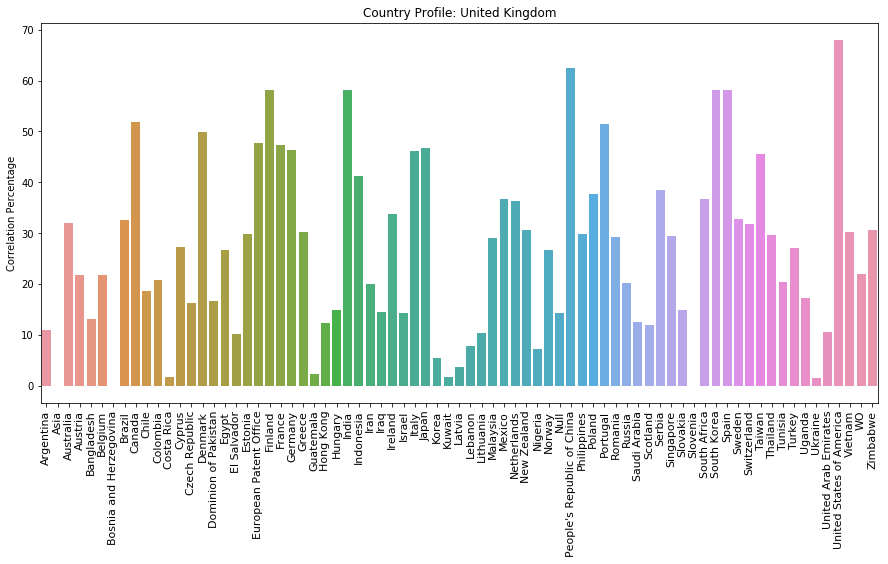

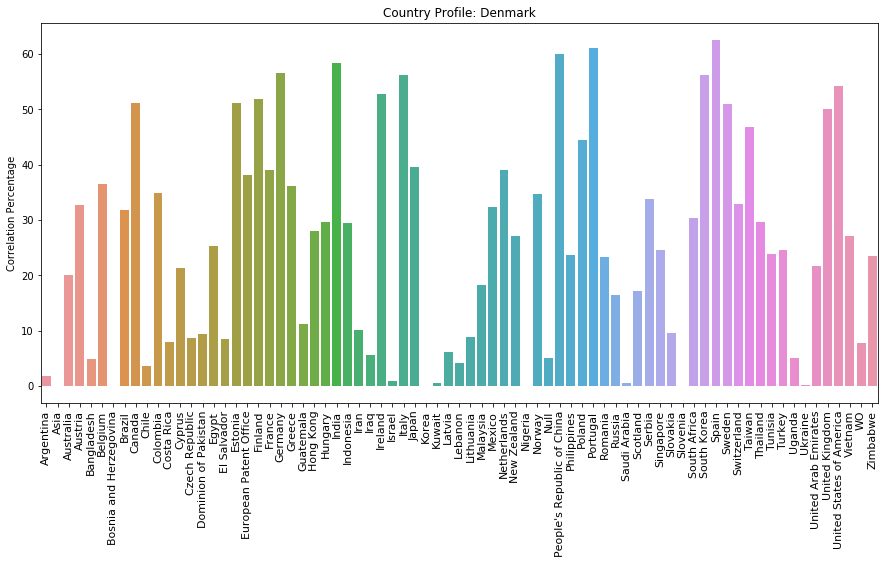

In [123]:
# for each country selected
for country in countries:
    
    # find the matrix slice
    country_index = find_index(country, country_names)
    histogram_data = country_correlation[:, country_index]
    
    # remove the country itself from data and labels
    histogram_data = np.delete(histogram_data, country_index)
    clean_country_names = np.delete(country_names, country_index)
    
    #
    plt.subplots(1,1,figsize=(15,7))
    sns.barplot(np.arange(len(histogram_data)), histogram_data * 100)
    plt.xticks(np.arange(len(histogram_data)), clean_country_names, rotation=90, fontsize=11)
    plt.title('Country Profile: {}'.format(country))
    plt.ylabel('Correlation Percentage')
    plt.show()

[INTERACTIVE PLOTLY VERSION](https://plot.ly/~duarteocarmo/20)

Some important information comes from these profiles: 
- Using these profile we can dive deeper into each country to confirm the above hypothesis. 
- Looking at UK's profile, the top three countries with highest correlation with it are: USA, China and India. This can mean that language is a very important factor for correlation but also eceonomic development for example. 
- Looking at Denmark's profile, the 3 most similar countries are: Spain, Portugal and China. This indicates that there is possibly another important factor at play. 

## 3. Contextual Relations (WIP) <a class="anchor" id="three"></a>

We will now study the relationship between the previously found correlations and other characteristics. 

### 3.1. GDP <a class="anchor" id="three-one"></a>

Let us investigate how the GDP is related to the capability correlations. 

The international monetary fund has GDP data available [here](http://www.imf.org/external/pubs/ft/weo/2017/02/weodata/weorept.aspx?pr.x=34&pr.y=13&sy=2017&ey=2017&scsm=1&ssd=1&sort=country&ds=.&br=1&c=512%2C946%2C914%2C137%2C612%2C546%2C614%2C962%2C311%2C674%2C213%2C676%2C911%2C548%2C193%2C556%2C122%2C678%2C912%2C181%2C313%2C867%2C419%2C682%2C513%2C684%2C316%2C273%2C913%2C868%2C124%2C921%2C339%2C948%2C638%2C943%2C514%2C686%2C218%2C688%2C963%2C518%2C616%2C728%2C223%2C836%2C516%2C558%2C918%2C138%2C748%2C196%2C618%2C278%2C624%2C692%2C522%2C694%2C622%2C142%2C156%2C449%2C626%2C564%2C628%2C565%2C228%2C283%2C924%2C853%2C233%2C288%2C632%2C293%2C636%2C566%2C634%2C964%2C238%2C182%2C662%2C359%2C960%2C453%2C423%2C968%2C935%2C922%2C128%2C714%2C611%2C862%2C321%2C135%2C243%2C716%2C248%2C456%2C469%2C722%2C253%2C942%2C642%2C718%2C643%2C724%2C939%2C576%2C644%2C936%2C819%2C961%2C172%2C813%2C132%2C726%2C646%2C199%2C648%2C733%2C915%2C184%2C134%2C524%2C652%2C361%2C174%2C362%2C328%2C364%2C258%2C732%2C656%2C366%2C654%2C734%2C336%2C144%2C263%2C146%2C268%2C463%2C532%2C528%2C944%2C923%2C176%2C738%2C534%2C578%2C536%2C537%2C429%2C742%2C433%2C866%2C178%2C369%2C436%2C744%2C136%2C186%2C343%2C925%2C158%2C869%2C439%2C746%2C916%2C926%2C664%2C466%2C826%2C112%2C542%2C111%2C967%2C298%2C443%2C927%2C917%2C846%2C544%2C299%2C941%2C582%2C446%2C474%2C666%2C754%2C668%2C698%2C672&s=NGDPD&grp=0&a=#cs75§w).

In the first hand, we should verify if all countries in our databse have GDP data available. 

Let's start by verifying. 

In [124]:
data = pd.read_csv('Data/gdp.csv', delimiter=';', header=None).as_matrix()
print 'Countries that do not have data:'
for country in country_names:
    if country not in data[:, 0]:
        print country

Countries that do not have data:
Asia
European Patent Office
Null
Scotland
South Korea
WO


/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



After that, we delete those entries from the `country_correlation` matrix (our heatmap) and create an `adapted_country_correlation` that is equal, without the entries that do not have GDP data available. 

In [125]:
countries_not_available = ['Asia', 'European Patent Office', 'Korea', 'Null', 'Scotland', 'South Korea', 'WO']
index_countries_not_available = [find_index(country, country_names) for country in countries_not_available]

adapted_country_correlation = np.delete(country_correlation, index_countries_not_available, 0)
adapted_country_correlation = np.delete(adapted_country_correlation, index_countries_not_available, 1)

Next, we create a matrix where the GDP's are correlated with each other. Following the structure: 
- Entry(i,j) is the absolute value of the difference between the GDP of country i and j.

In [126]:
# create the matrix
gdps = np.zeros([adapted_country_correlation.shape[0], adapted_country_correlation.shape[0]])
countries_available = [country for country in country_names if country not in countries_not_available]
countries_available.sort()

# for every entry, calculate the entry
for row in range(len(countries_available)):
    country_1 = countries_available[row]
    country_1_gdp = float(data[find_index(country_1, data[:, 0].tolist()), 1])
    for column in range(len(countries_available)):
        country_2 = countries_available[column]
        country_2_gdp = float(data[find_index(country_2, data[:, 0].tolist()), 1])
    
        gdps[row, column] = abs(country_1_gdp - country_2_gdp)

# normalize the matrix
gdps_norm = (gdps - np.mean(gdps)) / np.std(gdps)

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



We can finally plot the GDP correlation heatmap. 

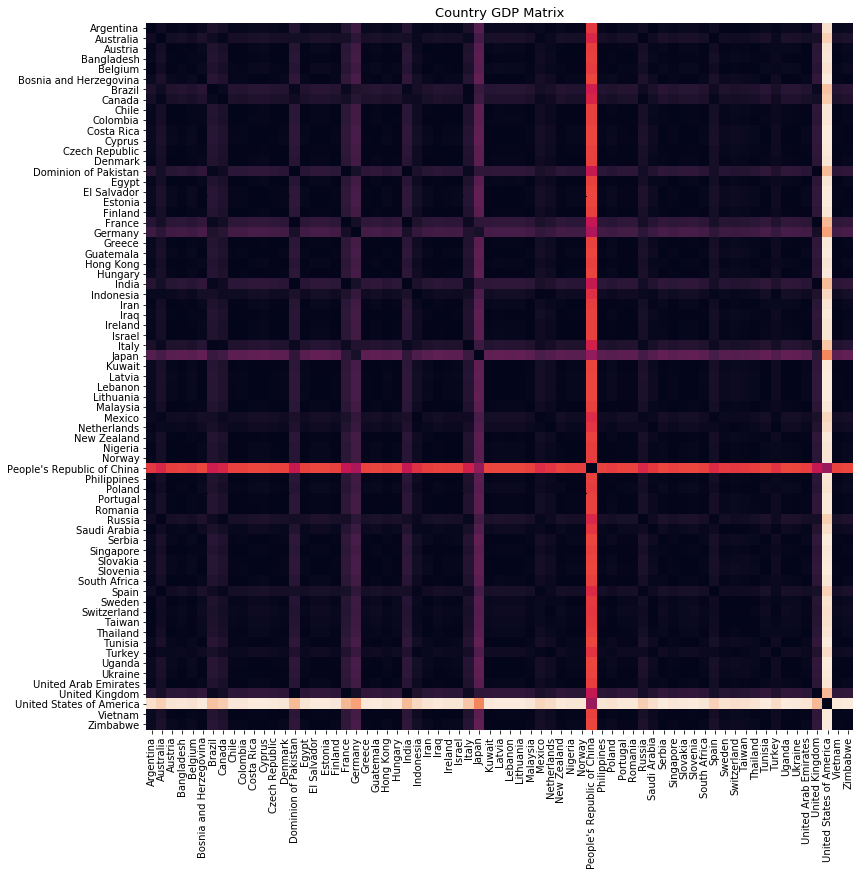

In [127]:
plt.subplots(1,1,figsize=(13,13))
plt.subplot(111)
sns.heatmap(gdps_norm, cbar=None, square=True, yticklabels=countries_available, xticklabels=countries_available)
plt.title('Country GDP Matrix', size=13)
plt.show()